# Penguins Dataset
O objetivo com esse banco de dados é classificar a espécie de penguins com uma decision tree.

In [19]:
#Importando pacotes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
#Carregando e limpando os dados
def just_first(data):
  vetor = str.split(data, sep = " ")
  return vetor[0]

def subs_sex(data):
  if data < 3800:
    sexo = "FEMALE"
  else:
    sexo = "MALE"
  return sexo

def clean_penguin():
  #agrupando os datasets
  adelie = pd.read_csv("https://portal.edirepository.org/nis/dataviewer?packageid=knb-lter-pal.219.3&entityid=002f3893385f710df69eeebe893144ff")
  gentoo = pd.read_csv("https://portal.edirepository.org/nis/dataviewer?packageid=knb-lter-pal.220.3&entityid=e03b43c924f226486f2f0ab6709d2381")
  chinstrap = pd.read_csv("https://portal.edirepository.org/nis/dataviewer?packageid=knb-lter-pal.221.2&entityid=fe853aa8f7a59aa84cdd3197619ef462")
  df = pd.concat([adelie, gentoo, chinstrap])
  #retirando colunas
  df = df.drop(["studyName","Sample Number","Region","Stage","Individual ID",
              "Clutch Completion", "Date Egg", "Delta 15 N (o/oo)",
              "Delta 13 C (o/oo)", "Comments"], axis = 1)
  #Nomes dos penguins
  df["Species"] = df.Species.apply(just_first)
  #Renomeando Colunas
  df.rename(columns={'Species':'species','Island':'island',
                   'Culmen Length (mm)': 'culmen_length', 'Culmen Depth (mm)': 'culmen_depth',
                   'Flipper Length (mm)':'flipper_length', 'Body Mass (g)':'body_mass',
                   'Sex':'sex'}, inplace=True)
  #Retirando observações faltantes
  df = df[df.loc[:,["culmen_depth","culmen_length","flipper_length","body_mass"]].notnull().any(axis = 1)]
  #substituindo o NaN pelo Sexo
  sexo_na = df[df.loc[:,["sex"]].isnull().any(axis = 1)]
  sexo_na.sex = sexo_na.body_mass.apply(subs_sex) 
  df = df[df.loc[:,["sex"]].notnull().any(axis = 1)]
  df.sex[df.sex == "."] = 'MALE'
  #Juntado tudo
  df_clean = pd.concat([df,sexo_na])
  return df_clean

penguins = clean_penguin()
penguins.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,species,island,culmen_length,culmen_depth,flipper_length,body_mass,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE


In [21]:
#Quantidade de cada especie de penguin
penguins.species.value_counts()

Adelie       151
Gentoo       123
Chinstrap     68
Name: species, dtype: int64

In [22]:
#Separacao em treino e teste
def split_train_test(data, test_ratio):
  per_ind = np.random.permutation(len(data))
  test_size = int(len(data) * test_ratio)
  test_ind = per_ind[:test_size]
  train_ind = per_ind[test_size:]
  return data.iloc[train_ind] , data.iloc[test_ind]

train, test = split_train_test(penguins,0.2)

In [23]:
#separando as preditoras do target
#exclui o sexo como preditora
X_train = train.iloc[:,1:6]
y_train = train.species
X_test = test.iloc[:,1:6]
y_test = test.species

In [24]:
#Transformando variaveis categoricas em dummies
X_train = pd.get_dummies(X_train, 'island')
X_test = pd.get_dummies(X_test, 'island')

In [25]:
#Arvore de decisao sem hyperparametros
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [26]:
#acurácia da arvore de decisão
predicao = tree.predict(X_train)
np.mean(predicao == y_train)

1.0

In [27]:
#Cross validation - acuracia
from sklearn.model_selection import cross_val_score
y_scores = cross_val_score(tree,
                             X_train,
                             y_train,
                             scoring = "accuracy",
                             cv = 10)
print(y_scores)

[1.         0.89285714 1.         1.         1.         1.
 0.96296296 1.         0.92592593 0.85185185]


# Com Hyperparametros

In [28]:
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

tree = DecisionTreeClassifier()

#hyperparametros possíveis
#O RandomizedSearchCV vai fazer combinações e achar a melhor combinação
param_dist = {"max_depth" : [3, 4, 5, None],
              "min_samples_leaf" : randint(1,9),
              "criterion" : ["gini","entropy"]}

tree_cv = RandomizedSearchCV(tree, param_dist, cv = 10)
tree_cv.fit(X_train,y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=None,
         

In [29]:
#melhor combinação
tree_cv.best_params_

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1}

In [30]:
#melhor resultado
tree_cv.best_score_

0.9632275132275131

In [31]:
#Performance no Treino
#Confusion Matrix
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_train, tree_cv.predict(X_train))
conf_mx

array([[122,   0,   0],
       [  5,  51,   0],
       [  1,   0,  95]])

In [32]:
#Performance no Teste
conf_mx = confusion_matrix(y_test, tree_cv.predict(X_test))
conf_mx

array([[29,  0,  0],
       [ 1, 11,  0],
       [ 0,  0, 27]])

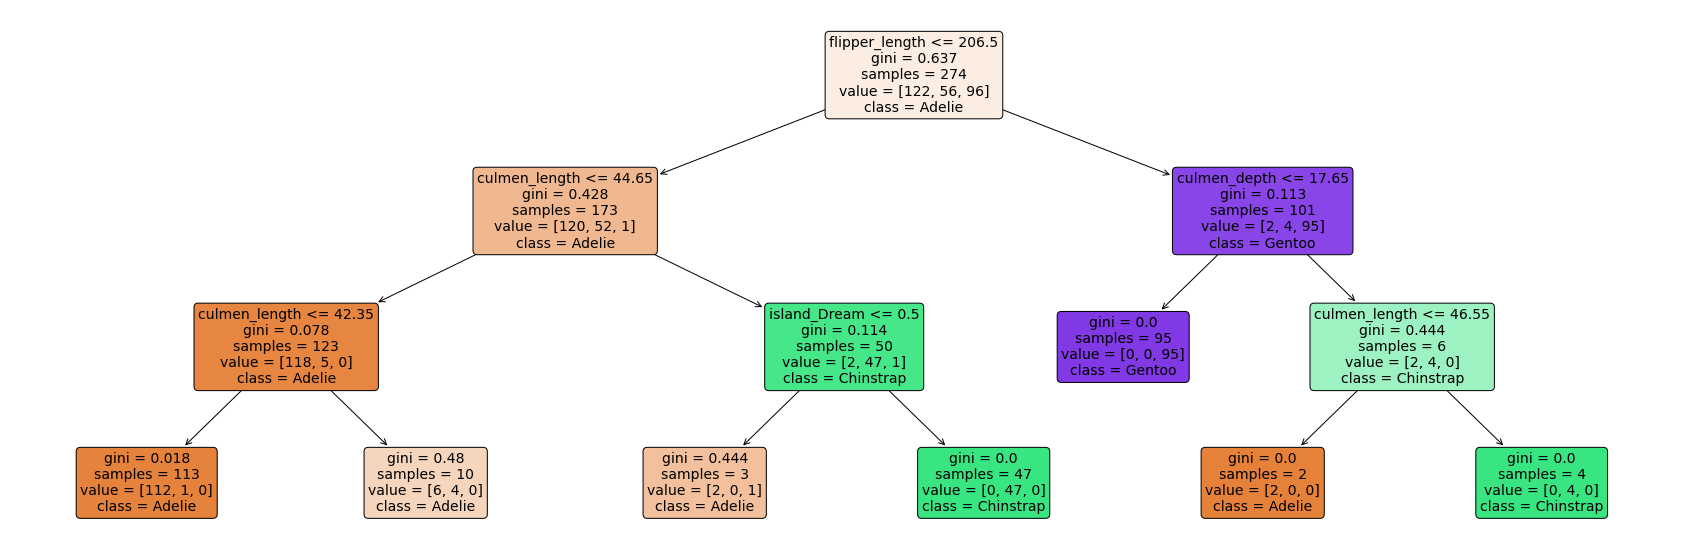

In [33]:
#Visualização
from sklearn.tree import plot_tree

plt.figure(figsize=(30,10))
a = plot_tree(tree_cv.best_estimator_,
              feature_names= X_train.columns, 
              class_names=np.unique([penguins.species]), 
              filled=True, 
              rounded=True, 
              fontsize=14)